In [6]:
from one.api import ONE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from brainbox.io.one import SpikeSortingLoader
from ibllib.io.extractors.ephys_fpga import extract_wheel_moves

In [1]:
from one.api import ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


In [2]:
def visualize_trial_filtering(times, trial_data, ts_bounded):
    stim_on_bounded = trial_data["stimOn_times"][np.logical_and(trial_data["stimOn_times"] >= times[0], trial_data["stimOn_times"] <= times[-1])]
    feedback_bounded = trial_data["feedback_times"][np.logical_and(trial_data["feedback_times"] >= times[0], trial_data["feedback_times"] <= times[-1])]
    plt.plot(times, np.where(ts_bounded, np.ones(ts_bounded.shape[0]), np.zeros(ts_bounded.shape[0])))
    plt.scatter(stim_on_bounded, np.ones(len(stim_on_bounded)), color="red")
    plt.scatter(feedback_bounded, np.ones(len(feedback_bounded)), color="purple")


def load_spike_features(eid, probe='probe00', bin_size=0.02):
    sl = SpikeSortingLoader(eid=eid, one=one,pname=probe)
    spikes, clusters, channels = sl.load_spike_sorting()
    clusters = sl.merge_clusters(spikes, clusters, channels)
    cluster_id = np.where(clusters['label'] == 1)
    print(f"Found {len(cluster_id[0])} clusters")

    # Convert to spike counts per time bin
    times = np.arange(2250, 2500, bin_size)   # np.arange(spikes['times'].min(), spikes['times'].max(), bin_size)
    spike_counts = np.zeros((len(times)-1, len(cluster_id[0])))
    for i, cluster in enumerate(cluster_id[0]):
        cluster_spikes = spikes['times'][spikes['clusters'] == cluster]
        spike_counts[:,i], _ = np.histogram(cluster_spikes, bins=times)
    
    # Only choose spikes where stimulus is turned on
    trial_data = one.load_object(eid, "trials", collection="alf")
    trial_times = []
    for stimon_t, trial_end_t in zip(trial_data["stimOn_times"],  trial_data["feedback_times"]):
        trial_times.append(np.logical_and(stimon_t <= times, times <= trial_end_t)[:-1])

    # ts_lowers = times >= trial_data["stimOn_times"][..., np.newaxis]
    # ts_uppers = times <= trial_data["feedback_times"][..., np.newaxis]
    # ts_bounded = np.logical_and(ts_lowers, ts_uppers)
    # ts_bounded[-1] = False
    # return times[ts_bounded], spike_counts[ts_bounded[:-1]]
    return times[:-1], trial_times, spike_counts

In [3]:
def select_features(spike_counts, threshold=5, min_units=25):
    # Dynamic threshold adjustment
    fr_mean = spike_counts.mean(0)
    fr_std = spike_counts.std(0)
    stability = fr_std / (fr_mean + 1e-6)

    # Ensure minimum unit count
    valid_units = stability < threshold
    print(f"Found {np.sum(valid_units)} stable units")
    if np.sum(valid_units) < min_units:
        valid_units = stability < np.quantile(stability, min_units/len(stability))
        print(f"Need >={min_units} stable units, selected {np.sum(valid_units)} by best stability")

    return spike_counts[:, valid_units]


def normalize_data(spike_counts, wheel_velos, spike_mean=None, spike_std=None, wheel_mean=None):
    # Z-score inputs.
    if spike_mean is None:
        spike_mean = np.nanmean(spike_counts,axis=0)
    if spike_std is None:
        spike_std = np.nanstd(spike_counts,axis=0)
    spike_counts = np.where(spike_std != 0, (spike_counts - spike_mean) / spike_std, spike_counts - spike_mean)

    # Zero-center outputs
    if wheel_mean is None:
        wheel_mean = np.mean(wheel_velos, axis=0)
    wheel_std = np.nanstd(wheel_velos, axis=0)
    wheel_velos = np.where(wheel_std != 0, (wheel_velos - wheel_mean) / wheel_std, wheel_velos - wheel_mean)
    return spike_counts, wheel_velos, spike_mean, spike_std, wheel_mean

In [4]:
def align_data(neural_times, trial_times, neural_features, wheel_times, wheel_velos):
    # Validate temporal overlap
    overlap_start, overlap_end = 0, neural_times.shape[0]
    if neural_times[0] < wheel_times[0]:
        overlap_start = np.where(neural_times >= wheel_times[0])[0][0]    # first timestamp bigger than wheel
    if neural_times[-1] > wheel_times[-1]:
        overlap_end = np.where(neural_times <= wheel_times[-1])[0][-1] + 1    # last timestamp smaller than wheel

    if overlap_start >= overlap_end:
        raise ValueError(
            f"No temporal overlap between neural ({neural_times[0]:.2f}-{neural_times[-1]:.2f}s) "
            f"and wheel ({wheel_times[0]:.2f}-{wheel_times[-1]:.2f}s) data"
        )

    # Unified timebase
    wheel_aligned, common_times, neural_aligned = [], [], []
    for trial_time in trial_times:
        trial_time[:overlap_start] = False
        trial_time[overlap_end:] = False
        if np.any(trial_time):
            common_time = neural_times[trial_time]
            common_times.append(common_time)
            neural_aligned.append(neural_features[trial_time])
            wheel_trial = np.interp(common_time, wheel_times, wheel_velos)
            wheel_aligned.append(wheel_trial)
    return common_times, neural_aligned, wheel_aligned

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from tqdm import tqdm

class NeuralDecoderMLP(nn.Module):
    def __init__(self, input_size, hidden_size=256, dropout=0.3):
        super().__init__()
        self.input = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.output = nn.Linear(hidden_size // 2, 1)

    def forward(self, x):
        x = self.input(x)
        y = self.output(x)
        return y.squeeze(-1)

def prepare_sequences(X, y, window=5):
    """Create temporal sequences for neural network input"""
    X_seq = np.zeros((len(X) - window, window * X.shape[1]))
    y_seq = np.zeros(len(X) - window)
    for i in range(len(X) - window):
        X_seq[i] = X[i : i + window].ravel()
        y_seq[i] = y[i + window]
    return X_seq, y_seq

def train_mlp_decoder(X, y, device='cuda', n_epochs=100):
    # Train/val split preserving temporal order
    X_seqs, y_seqs = [], []
    for X_trial, y_trial in zip(X, y):
        X_seq, y_seq = prepare_sequences(X_trial, y_trial)
        X_seqs.append(X_seq)
        y_seqs.append(y_seq)
    split = int(0.8*len(X))
    X_train, X_val = X_seqs[:split], X_seqs[split:]
    y_train, y_val = y_seqs[:split], y_seqs[split:]

    # Model configuration
    model = NeuralDecoderMLP(input_size=X_seq.shape[1]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-4)
    loss_fn = nn.HuberLoss()

    # Training loop with early stopping
    best_val_r2 = -np.inf
    patience_counter = 0
    all_losses = []
    for epoch in tqdm(range(n_epochs), "Training"):
        model.train()
        for X_seq, y_seq in zip(X_train, y_train):
            # Convert to PyTorch tensors
            train_data = TensorDataset(torch.FloatTensor(X_seq),
                                    torch.FloatTensor(y_seq))
            train_loader = DataLoader(train_data, batch_size=256)
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                pred = model(X_batch.to(device))
                loss = loss_fn(pred, y_batch.to(device))
                loss.backward()
                all_losses.append(loss.item())
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

        # Validation
        model.eval()
        val_preds = []
        val_targets = []  # Accumulate true values as well
        for X_seq, y_seq in zip(X_val, y_val):
            val_data = TensorDataset(torch.FloatTensor(X_seq),
                                    torch.FloatTensor(y_seq))
            with torch.no_grad():
                val_loader = DataLoader(val_data, batch_size=256)
                for X_val_batch, y_val_batch in val_loader:
                    pred = model(X_val_batch.to(device)).cpu().numpy()
                    val_preds.extend(pred)  # Use extend for adding individual items
                    val_targets.extend(y_val_batch.cpu().numpy())  # Collect true values

        # Calculate R2 outside the loop on full arrays
        val_r2 = r2_score(val_targets, val_preds)

        # Early stopping
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= 10:
            break
    
    return model, best_val_r2, all_losses

In [ ]:
if __name__ == "__main__":
    # Modified main analysis loop
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    for eid in eids[:1]:
        # try:
            # Data loading (same as before)
            neural_times, spike_counts = load_spike_features(eid)
            wheel_data = one.load_object(eid, 'wheel', collection='alf')
            wheel_velos = np.gradient(wheel_data["position"], wheel_data["timestamps"])

            # Feature selection and alignment
            stable_spikes = select_features(spike_counts)
            norm_spikes, wheel_velos, spike_mean, spike_std, wheel_mean = normalize_data(stable_spikes, wheel_velos)
            common_time, X_aligned, y_aligned = align_data(neural_times, norm_spikes, wheel_data["timestamps"], wheel_velos)

            # Train MLP decoder
            model, best_val_r2, all_losses = train_mlp_decoder(X_aligned, y_aligned, device=device)
            print(f"Session {eid} achieved Validation R²={best_val_r2:.3f}")

            # Full sequence prediction
            X_full, y_full = prepare_sequences(X_aligned, y_aligned)
            with torch.no_grad():
                full_pred = model(torch.FloatTensor(X_full).to(device)).cpu().numpy()

            # Visualization with temporal offset
            plt.figure(figsize=(12,4))
            plt.plot(common_time[15:], y_full, label='Actual Speed')
            plt.plot(common_time[15:], full_pred, label='MLP Prediction')
            plt.xlabel('Time (s)')
            plt.ylabel('Wheel Speed (cm/s)')
            plt.legend()
            plt.title(f'MLP Decoding Performance - {eid}')
            plt.show()

        # except Exception as e:
        #     print(f"Error processing {eid}: {str(e)}")

In [7]:
eid = "c51f34d8-42f6-4c9c-bb5b-669fd9c42cd9"
neural_times, trial_times, spike_counts = load_spike_features(eid)
wheel_data = one.load_object(eid, 'wheel', collection='alf')
wheel_velos = np.gradient(wheel_data["position"], wheel_data["timestamps"])

# Feature selection and alignment
stable_spikes = select_features(spike_counts, 0.3)
common_times, spikes_aligned, wheel_aligned = align_data(neural_times, trial_times, stable_spikes, wheel_data["timestamps"], wheel_velos)
for trial_i in range(len(common_times)):
    spikes_norm, wheel_norm, spike_mean, spike_std, wheel_mean = normalize_data(spikes_aligned[trial_i], wheel_aligned[trial_i])
    spikes_aligned[trial_i] = spikes_norm
    wheel_aligned[trial_i] = wheel_norm

Found 154 clusters
Found 86 stable units


/tmp/ipykernel_418309/94661471.py:23: RuntimeWarning: invalid value encountered in divide
  spike_counts = np.where(spike_std != 0, (spike_counts - spike_mean) / spike_std, spike_counts - spike_mean)


In [8]:
model, best_val_r2, all_losses = train_mlp_decoder(spikes_aligned, wheel_aligned, device="cuda")
print(f"Session {eid} achieved Validation R²={best_val_r2:.3f}")

Training: 100%|██████████| 100/100 [00:07<00:00, 12.54it/s]

Session c51f34d8-42f6-4c9c-bb5b-669fd9c42cd9 achieved Validation R²=-0.000


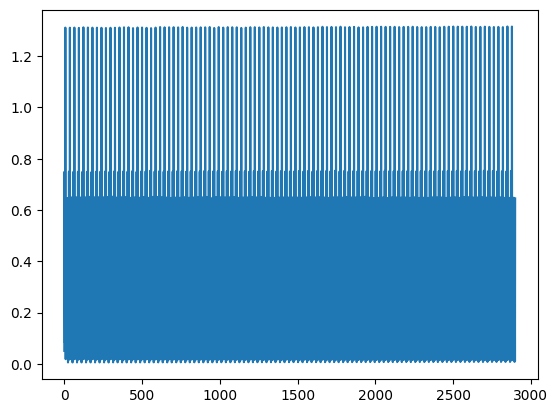

In [9]:
plt.plot(list(range(len(all_losses))), all_losses)

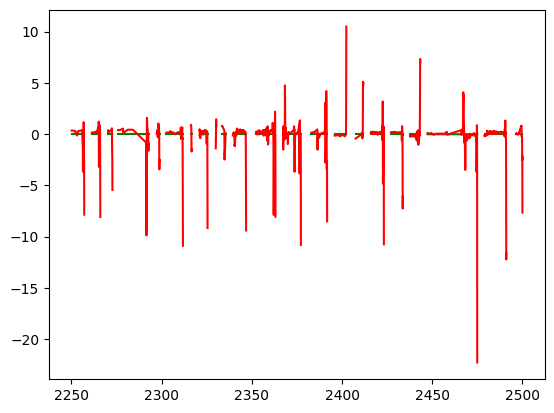

In [10]:
for common_time, spikes, wheel in zip(common_times, spikes_aligned, wheel_aligned):
    X_test, y_test = prepare_sequences(spikes, wheel)
    y_pred = model(torch.tensor(X_test, dtype=torch.float).to("cuda"))
    plt.plot(common_time[5:], y_pred.detach().cpu(), color="green")
    plt.plot(common_time[5:], y_test, color="red")

In [10]:
sl = SpikeSortingLoader(eid=eid, one=one, pname="probe00")
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)
cluster_id = np.where(clusters['label'] == 1)

(<Figure size 1600x900 with 4 Axes>,
 array([[<Axes: title={'center': '2021-06-28_1_NYU-48_probe00, None \n6_136_704 spikes, 693 clusters'}>,
         <Axes: >],
        [<Axes: xlabel='time (secs)', ylabel='depth (um)'>,
         <Axes: title={'center': 'alf'}>]], dtype=object))

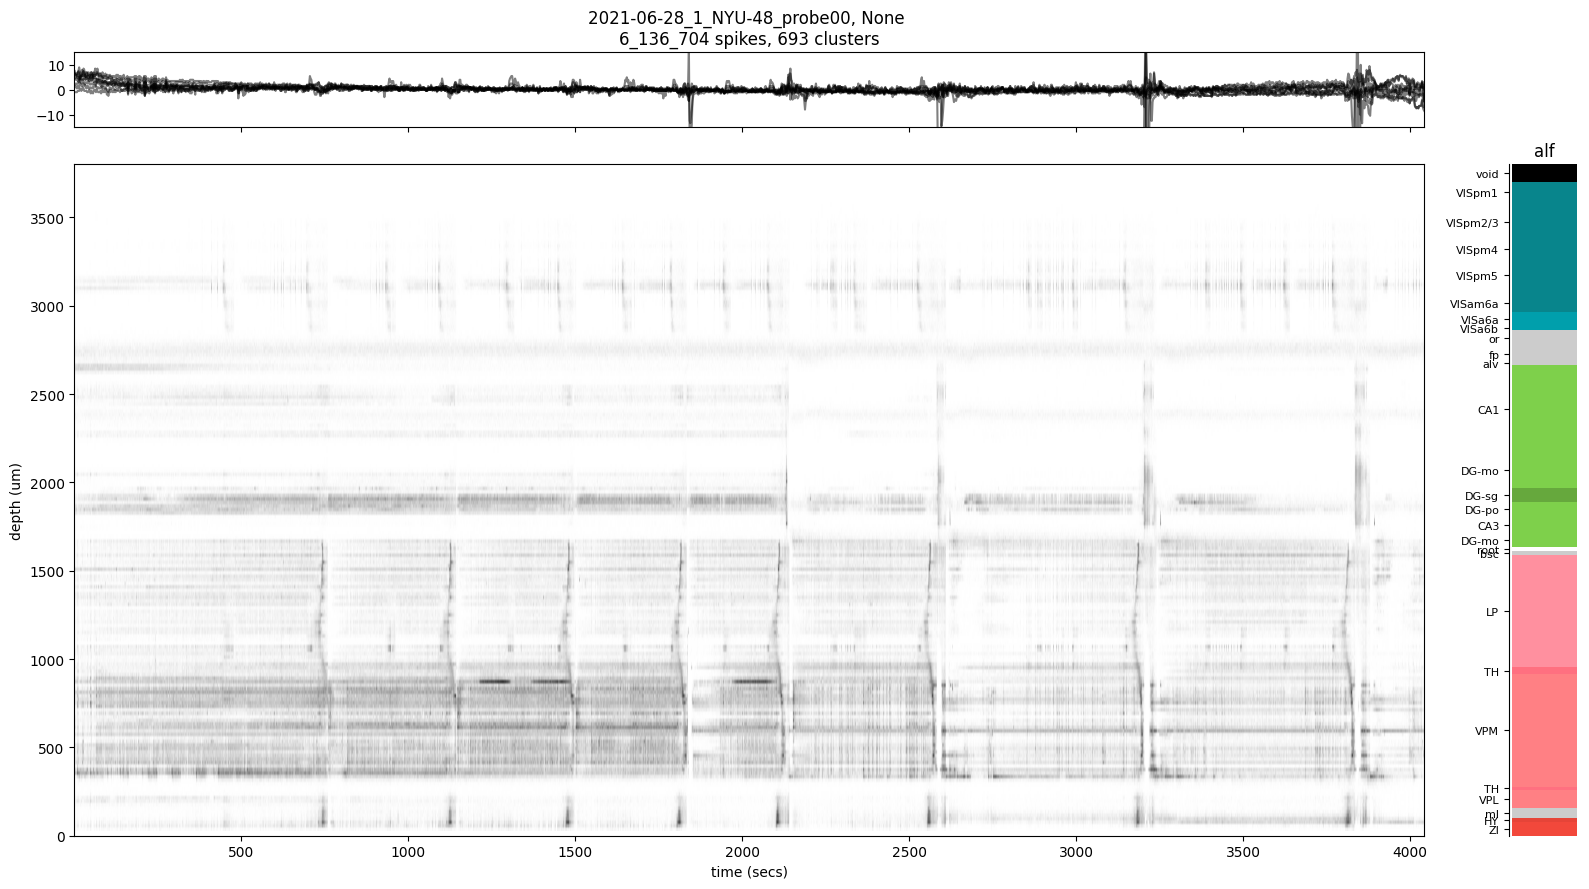

In [11]:
sl.raster(spikes, channels)